In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

Initialize Dataset

In [2]:
import kagglehub

path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.


In [3]:
path = "/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"

In [28]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data = pd.read_csv(path, header=0, names=["text", "label"])
data['text'] = data['text'].str.lower().str.split()

data['label'] = LabelEncoder().fit_transform(data['label'])
data['length'] = data['text'].apply(len)

vocab = list({word for phrase in data['text'] for word in phrase})
index_word = {word: i for i, word in enumerate(vocab, start=1)}

max_length = data['text'].str.len().max()

def encode_and_pad(text):
  encoded = [index_word[word] for word in text]
  return encoded + [0]*(max_length - len(encoded))

train_data, test_data = train_test_split(data, test_size=0.2, random_state = 42)

train_data['text'] = train_data['text'].apply(encode_and_pad)
test_data['text'] = test_data['text'].apply(encode_and_pad)

short_test = test_data[test_data['length'] < 100]
medium_test = test_data[(test_data['length'] >=100 ) & (test_data['length'] <=300)]
long_test = test_data[test_data['length'] > 300]


Create Dataloaders for each dataset

In [21]:
from torch.utils.data import Dataset, DataLoader
class SentimentDataset(Dataset):
    def __init__(self, data):
        self.texts = data['text'].values
        self.labels = data['label'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

train_dataset = SentimentDataset(train_data)
short_dataset = SentimentDataset(short_test)
medium_dataset = SentimentDataset(medium_test)
long_dataset = SentimentDataset(long_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
short_loader = DataLoader(short_dataset, batch_size=64, shuffle=False)
medium_loader = DataLoader(medium_dataset, batch_size=64, shuffle=False)
long_loader = DataLoader(long_dataset, batch_size=64, shuffle=False)

Defining the RNN Model

In [10]:
class SentimentRNN(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, output_size):
    super(SentimentRNN, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.RNN(embed_size, hidden_size, batch_first = True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x=self.embedding(x)
    h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
    out, _ = self.rnn(x,h0)
    out.requires_grad_(True)
    out.retain_grad()
    logits = self.fc(out[:, -1, :])

    return logits, out

vocab_size = len(vocab) + 1
embed_size = 64
hidden_size = 64
output_size = 2
model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Actual Training

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  for text, labels in train_loader:

    text = text.to(device)
    labels =labels.to(device)

    outputs, _ = model(text)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Sub-Task 1

In [15]:
model.eval()

def check_accuracy(data_loader):
  correct = 0
  total = 0
  with torch.no_grad():
    for texts, labels in data_loader:

      texts = texts.to(device)
      labels = labels.to(device)
      outputs, _ = model(texts)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(accuracy)

print("Short Loader Accuracy: ", end="")
check_accuracy(short_loader)
print("Medium Loader Accuracy: ", end="")
check_accuracy(medium_loader)
print("Long Loader Accuracy: ", end="")
check_accuracy(long_loader)

Short Loader Accuracy: 55.67612687813022
Medium Loader Accuracy: 49.153059667327945
Long Loader Accuracy: 51.17830146731881


Sub-Task 2

In [34]:
new_test = medium_test.iloc[0]

text = torch.tensor(new_test['text']).unsqueeze(0)
label = torch.tensor(new_test['label']).unsqueeze(0)

model.train()
text = text.to(device)
label = label.to(device)

logits, out = model(text)
loss = criterion(logits, label)
optimizer.zero_grad()
loss.backward()
optimizer.step()

grad_norms = torch.norm(out.grad.squeeze(0), dim=1)

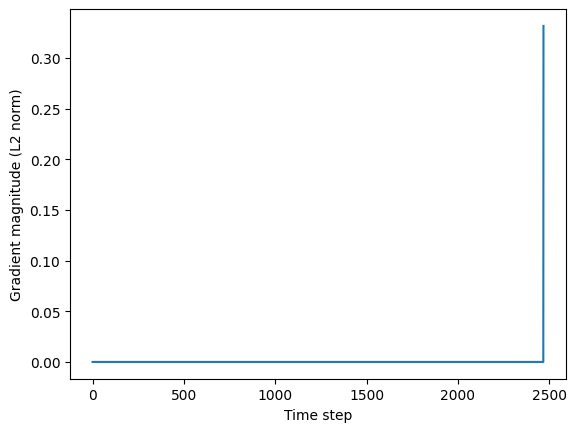

In [35]:
plt.figure()
plt.plot(grad_norms.cpu().numpy())
plt.xlabel("Time step")
plt.ylabel("Gradient magnitude (L2 norm)")
plt.show()